In [1]:
from avalanche.benchmarks import SplitMNIST

benchmark = SplitMNIST(n_experiences=2)

train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

for experience in train_stream: 
    print("Start of task ", experience.task_label)
    print('Classes in this task:', experience.classes_in_this_experience)

    current_training_set = experience.dataset
    print('Task {}'.format(experience.task_label))
    print('This task contains', len(current_training_set), 'training examples')

    current_test_set = test_stream[experience.current_experience].dataset
    print('This task contains', len(current_test_set), 'test examples')


/Users/daniyarzakarin/miniconda3/envs/clenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/daniyarzakarin/miniconda3/envs/clenv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/daniyarzakarin/miniconda3/envs/clenv/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /Users/daniyarzakarin/miniconda3/envs/clenv/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/daniyarzakarin/miniconda3/envs/clenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress 

Start of task  0
Classes in this task: [0, 1, 2, 7, 8]
Task 0
This task contains 30739 training examples
This task contains 5149 test examples
Start of task  0
Classes in this task: [3, 4, 5, 6, 9]
Task 0
This task contains 29261 training examples
This task contains 4851 test examples


Defining the file logger

In [2]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
    accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
    confusion_matrix_metrics, disk_usage_metrics, StreamConfusionMatrix
from avalanche.logging import InteractiveLogger

text_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    StreamConfusionMatrix(num_classes=benchmark.n_classes, save_image=False),
    loggers=[text_logger]
)

Models and Strategies

In [3]:
from avalanche.models import SimpleMLP
from avalanche.training import Naive, EWC
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

mlp_naive = SimpleMLP(num_classes=benchmark.n_classes)
naive_strategy = Naive(
    model = mlp_naive, 
    optimizer = SGD(mlp_naive.parameters(), lr=0.001, momentum=0.9),
    criterion = CrossEntropyLoss(), 
    train_mb_size=500, 
    train_epochs=10, 
    eval_mb_size=100,
    evaluator=eval_plugin)

mlp_ewc = SimpleMLP(num_classes=benchmark.n_classes)
ewc_strategy = EWC(
    model = mlp_ewc, 
    optimizer = SGD(mlp_ewc.parameters(), lr=0.001, momentum=0.9),
    criterion = CrossEntropyLoss(), 
    ewc_lambda = 2000,
    train_mb_size=500, 
    train_epochs=10, 
    eval_mb_size=100,
    evaluator=eval_plugin)



Training

In [4]:
results_naive = []
print('Starting experiment...')

for exp_id, experience in enumerate(train_stream):
    print("Start of experience ", experience.current_experience)

    naive_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the current test set')
    results_naive.append(naive_strategy.eval(benchmark.test_stream[exp_id]))

print('Final evaluation...')
naive_strategy.eval(benchmark.test_stream)

Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 62/62 [00:05<00:00, 12.19it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2072
	Loss_MB/train_phase/train_stream/Task000 = 0.4758
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6856
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9038
100%|██████████| 62/62 [00:04<00:00, 13.11it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3935
	Loss_MB/train_phase/train_stream/Task000 = 0.3483
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9033
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8912
100%|██████████| 62/62 [00:05<00:00, 12.12it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2881
	Loss_MB/train_phase/train_stream/Task000 = 0.2399
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9202
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9163
100%|██████████| 62/62 [00:04<00:00, 14.24it/s]
Epoch 3 ended.
	Loss_Epoch/

{'Top1_Acc_MB/train_phase/train_stream/Task000': 0.9272030651340997,
 'Loss_MB/train_phase/train_stream/Task000': 0.20209628343582153,
 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9190389938826424,
 'Loss_Epoch/train_phase/train_stream/Task000': 0.25599117917000264,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.009322198485142746,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 5.7928380825422785,
 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.4572,
 'Loss_Stream/eval_phase/test_stream/Task000': 3.085521245234832,
 'StreamForgetting/eval_phase/test_stream': 0.9489221208001554,
 'ConfusionMatrix_Stream/eval_phase/test_stream': tensor([[  0,   0,   0,  35,   3, 879,  56,   0,   0,   7],
         [  0,  48,   0, 990,   2,  81,  13,   0,   0,   1],
         [  0,   0,   0, 632,  46,  31, 273,   0,   0,  50],
         [  0,   0,   0, 953,   3,  29,   4,   0,   0,  21],
         [  0,   0,   0,   2, 929,   2,  15,   0,   0,  34],
         [  0,   0,   0,  38,  12

In [14]:
results_ewc = []
print('Starting experiment...')

for exp_id, experience in enumerate(train_stream):
    print("Start of experience ", experience.current_experience)

    ewc_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the current test set')
    results_ewc.append(ewc_strategy.eval(benchmark.test_stream[exp_id]))

print('Final evaluation...')
ewc_strategy.eval(benchmark.test_stream)

Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 61/61 [00:04<00:00, 13.46it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2564
	Loss_MB/train_phase/train_stream/Task000 = 0.5641
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6558
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8842
100%|██████████| 61/61 [00:04<00:00, 13.94it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4232
	Loss_MB/train_phase/train_stream/Task000 = 0.3516
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8949
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9243
100%|██████████| 61/61 [00:04<00:00, 13.79it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3088
	Loss_MB/train_phase/train_stream/Task000 = 0.2859
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9129
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9125
100%|██████████| 61/61 [00:04<00:00, 13.86it/s]
Epoch 3 ended.
	Loss_Epoch/

{'Top1_Acc_MB/train_phase/train_stream/Task000': 0.922077922077922,
 'Loss_MB/train_phase/train_stream/Task000': 0.21081849932670593,
 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9380599790377658,
 'Loss_Epoch/train_phase/train_stream/Task000': 0.23651596240989736,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.10818713450292397,
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 3.9334067754578173,
 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.5186,
 'Loss_Stream/eval_phase/test_stream/Task000': 2.0981782685741783,
 'StreamForgetting/eval_phase/test_stream': 0.849317738791423,
 'ConfusionMatrix_Stream/eval_phase/test_stream': tensor([[  0,   0,   0,  40,   1, 836,  96,   7,   0,   0],
         [  0, 497,   0, 468,   6,  37,  11, 116,   0,   0],
         [  0,   0,  58, 523,  65,  32, 304,  50,   0,   0],
         [  0,   0,   0, 955,   2,  23,   4,  26,   0,   0],
         [  0,   0,   0,   1, 955,   3,  16,   7,   0,   0],
         [  0,   0,   0,  43,  16, 

In [68]:
from json import load
from utilities import get_hessian_eigenvalues
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.relu = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc = nn.Linear(input_size, output_size, bias = False)

    def forward(self, x):
        # x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        x = self.fc(x)
        return x

# Initialize model, loss function, and optimizer
input_size = 10      # number of input features
hidden_size = 20     # number of hidden units
output_size = 1      # number of output units

model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()           # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for demonstration
inputs = torch.randn(64, input_size)   # 64 samples, each with `input_size` features
targets = torch.randn(64, output_size) # Corresponding targets
learning_rate = 0.01
# Training loop
num_epochs = 100
dataset = TensorDataset(inputs, targets)
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    evals, evecs = get_hessian_eigenvalues(model, criterion, dataset, physical_batch_size=64)
    evecs.transpose_(1, 0)
    # evecs = torch.transpose(evecs)
    print(f'evecs.shape : {evecs.shape}')
    # print(f'proj_tensor: {proj_tensor.shape}')

    # Backward pass
    # loss.backward()  # Compute gradients
    
    # Manually update weights
    with torch.no_grad():  # Ensure we don’t track these operations for gradient computation
        grad = torch.autograd.grad(loss, inputs=model.parameters(), create_graph=True)
        vec_grad = parameters_to_vector(grad)
        print(f'vec_grad.shape: {vec_grad.shape}')
        step = torch.Tensor(vec_grad.shape)
        for vec in evecs:
            step -= learning_rate * torch.dot(vec_grad, vec) * vec  # Update each parameter by gradient descent
        vec_params = parameters_to_vector(model.parameters())
        vec_params += step
        vector_to_parameters(vec_params, model.parameters())
        model.zero_grad()
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}]')


# 
# loader = DataLoader(dataset, batch_size=64, shuffle=False)
# for kek, lol in loader:
#     print(kek.shape, lol.shape)
# 

evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
Epoch [10/100]
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shape: torch.Size([10])
evecs.shape : torch.Size([6, 10])
vec_grad.shap

In [ ]:
def projected_step_bulk(model, loss, criterion, dataset, batch_size):
    evals, evecs = get_hessian_eigenvalues(model, criterion, dataset, physical_batch_size=batch_size)
    evecs.transpose_(1, 0)
    
    with torch.no_grad():  # Ensure we don’t track these operations for gradient computation
        grad = torch.autograd.grad(loss, inputs=model.parameters(), create_graph=True)
        vec_grad = parameters_to_vector(grad)
        step = vec_grad.detach() 
        for vec in evecs:
            step -= torch.dot(vec_grad, vec) * vec  # Update each parameter by gradient descent
        vec_params = parameters_to_vector(model.parameters())
        vec_params -= step * learning_rate
        vector_to_parameters(vec_params, model.parameters())
        model.zero_grad()

In [ ]:
from json import load
from utilities import get_hessian_eigenvalues
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        # self.fc = nn.Linear(input_size, output_size, bias = False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.fc(x)
        return x

# Initialize model, loss function, and optimizer
input_size = 10      # number of input features
hidden_size = 20     # number of hidden units
output_size = 1      # number of output units

model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()           # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy data for demonstration
inputs = torch.randn(64, input_size)   # 64 samples, each with `input_size` features
targets = torch.randn(64, output_size) # Corresponding targets
learning_rate = 0.01
# Training loop
num_epochs = 100
dataset = TensorDataset(inputs, targets)
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    projected_step_bulk(model, loss, criterion, dataset, batch_size=64)
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] loss = {loss.item()}')


# 
# loader = DataLoader(dataset, batch_size=64, shuffle=False)
# for kek, lol in loader:
#     print(kek.shape, lol.shape)
# 

Epoch [10/100] loss = 0.8144099712371826
Epoch [20/100] loss = 0.8066299557685852
Epoch [30/100] loss = 0.798613429069519
Epoch [40/100] loss = 0.7902948260307312
Epoch [50/100] loss = 0.7818781733512878
Epoch [60/100] loss = 0.7729998826980591
Epoch [70/100] loss = 0.7637898325920105
Epoch [80/100] loss = 0.7540335059165955
Epoch [90/100] loss = 0.7437845468521118
Epoch [100/100] loss = 0.7331085205078125


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image to a 784-dimensional vector
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 128     # Number of units in the hidden layer
output_size = 10      # Number of classes for MNIST digits (0–9)
batch_size = 64
learning_rate = 0.01
num_epochs = 5


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Create a subset of 10% of the training dataset
train_size = 5000  # 10% of the data
indices = np.random.choice(len(full_train_dataset), train_size, replace=False)
train_dataset = Subset(full_train_dataset, indices)

# Use the entire test dataset for evaluation
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)



# Training loop
# Training loop
losses = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(f'loss = {loss.item()}')
    # print(f'Completed {epoch + 1}/{num_epochs}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Started bulk-GD')
for epoch in range(num_epochs):
    sum_loss = torch.tensor(0.0)
    batches = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        print(f'loss = {loss.item()}')
        losses.append(loss.item())
        sum_loss += loss
        batches += 1
        
    print(f'average_loss: {sum_loss / batches}')
    projected_step_bulk(model, sum_loss, criterion, train_dataset, batch_size=64)

        
    # print(f'Completed {epoch + 1}/{num_epochs}')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')




# Testing loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 1.6079
Epoch [2/5], Loss: 1.1114
Epoch [3/5], Loss: 0.8106
Epoch [4/5], Loss: 0.7819
Epoch [5/5], Loss: 1.0032
Started bulk-GD
loss = 0.6175386905670166
loss = 0.6685801148414612
loss = 0.5672411918640137
loss = 0.7241905331611633
loss = 0.5184228420257568
loss = 0.6765264272689819
loss = 0.5570483207702637
loss = 0.520581841468811
loss = 0.6423359513282776
loss = 0.7125670313835144
loss = 0.5165165066719055
loss = 0.6393201947212219
loss = 0.7577792406082153
loss = 0.6570294499397278
loss = 0.7472308874130249
loss = 0.5692609548568726
loss = 0.606831967830658
loss = 0.8656203746795654
loss = 0.49272921681404114
loss = 0.5099841356277466
loss = 0.6835612058639526
loss = 0.628917932510376
loss = 0.4078996181488037
loss = 0.5790503025054932
loss = 0.5093106627464294
loss = 0.5036419034004211
loss = 0.6101067066192627
loss = 0.5914376378059387
loss = 0.6565431952476501
loss = 0.6435202360153198
loss = 0.6197502017021179
loss = 0.6169801354408264
loss = 0.561001479625701

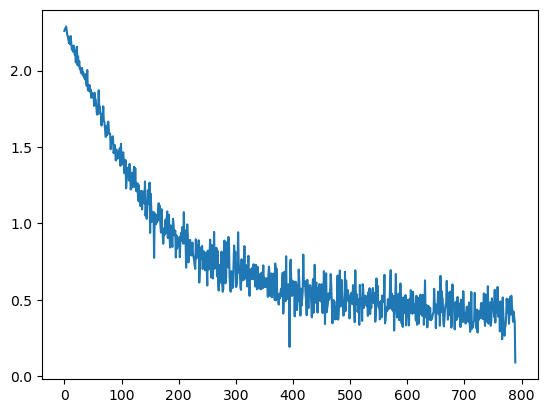

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses)

240 * 240 * 

In [2]:
print(evecs.shape)

torch.Size([241, 6])
